# Project: Developing a Binomial NPV-based Equity Trade Rule
At time $t$, the binomial lattice model predicts the share price $S_{t}$ is governed by:

$$
\begin{equation*}
S_{t} = S_{\circ}\cdot{u}^{t-k}\cdot{d}^{k}\qquad\text{for}\quad{k=0,1,\dots,t}
\end{equation*}
$$

where $S_{\circ}$ is the initial share price at time $t_{\circ}$, $u$ is the $\texttt{up}$ factor, 
and $d$ is the $\texttt{down}$ factor. The probability that share price takes on a particular value at time $t$ is given by:

$$
\begin{equation*}
P(S_{t} = S_{\circ}\cdot{u}^{t-k}\cdot{d}^{k}) = \binom{t}{k}\cdot{(1-p)}^{k}\cdot{p}^{t-k}\qquad\text{for}\quad{k=0,1,\dots,t}
\end{equation*}
$$

where $p$ is the probability of an $\texttt{up}$ move, and $1-p$ is the probability of a $\texttt{down}$ move. 
Putting this together with our _short-term trade rule_ (where we have assumed a negligible discount $\mathcal{D}_{t,0}(\bar{r})\simeq{1}$) gives a value for the distribution of scaled Net Present Values (NPVs), i.e., a restatement of the fractional return at time `t`:

$$
\begin{equation*}
\frac{\text{NPV}_{t}}{n_{\circ}S_{\circ}}\in\left\{u^{t-k}\cdot{d}^{k} - 1\right\}_{k=0}^{k=t}
\end{equation*}
$$

## Learning objectives
The aim of this example is to help students construct binomial lattice simulations of future share prices to compute the physical and risk-neutral probability of a successful trade. Toward this goal, we will:
* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-29-2023`.
* __Objective 1__: Compute the lattice parameters $(u,d,p)$ for all tickers in our price dataset
    * `TODO`: Estimate `real-world` lattice model parameters
    * `TODO`: Estimate `risk-neutral` lattice model parameters
    * `Discussion`: Compare real-world and risk-neutral probabilities
* __Objective 2__: Manually compute the price and probability values for the leaves of a binomial tree using the analytical expression
    * `Check`: Compare the analytical price and probability calculations versus those from the [VLQuantitativeFinancePackage.jl package](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git)
* __Objective 3__: Compute the Probability of Profit of an equity trade via sampling
    * `TODO`: Estimate the cumulative distribution of the equity fractional return
    * `TODO`: Visualize the cumulative distribution function

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-1/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-1/Manifest.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
Precompiling project...
  ✓ VLQuantitativeFinancePackage
  1 dependency successfully precompiled in 3 seconds. 259 already precompiled.
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-1`
 

### Packages
The `Include.jl` file loads several packages that we use for our exercises:
* [Dates. jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library that provides basic working date functionality.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table, and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package with the standard library module containing basic statistics functionality.

### Types
`Include. jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the lattice model simulation of equity share prices:

The `MyBinomialEquityPriceTree` encodes the lattice model and has the fields:
    
* The `connectivity::Union{Nothing, Dict{Int64, Array{Int64,1}}}` field holds the indexes of the children for each parent node of the tree.
* The `levels::Union{Nothing, Dict{Int64, Array{Int64,1}}}` field holds indexes of nodes that belong to each level of the tree, i.e., a trading day.
* The `u::Float64` field holds the value of the `up` factor
* The `d::Float64` field holds the value of the `down` factor
* The `p::Float64` field holds the value of the probability of an `up` move.
* The `data::Union{Nothing, Dict{Int64, MyBiomialLatticeEquityNodeModel}}` holds each node in the tree; nodes are of type `MyBiomialLatticeEquityNodeModel`

Each node in the tree is a `MyBiomialLatticeEquityNodeModel` type, which has two important fields:
* The `price::Float64` field holds the price value for a node
* The `probability::Float64` field holds the probability value associated with this node

### Functions
`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`MyPortfolioDataSet() |> x-> x["dataset"] -> DataFrame` 
 > This function loads historical share price data. The historical share price data is returned to the caller as a Dictionary of [DataFrames](https://dataframes.juliadata.org/stable/) with the fields: `volume,` `volume_weighted_average_price,` `open,` `close,` `high,` and `low,number_of_transactions`. The `keys` of the Dictionary are `firm_id` values.
 
`function analyze(R::Array{Float64,1};  Δt::Float64 = (1.0/252.0)) -> Tuple{Float64,Float64,Float64}`
> The `analyze(...)` function takes an array of logarithmic return values in the `R` argument and a value of the time-step size of the simulation in the $\Delta{t}$ parameter (default value of 1-day) and returns estimated values for the lattice model parameters $(u,d,p)$.  
`function build(model::Type{MyBinomialEquityPriceTree}, data::NamedTuple) -> MyBinomialEquityPriceTree` 
> This function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(u,d,p)$ values) and returns an instance of the `MyBinomialEquityPriceTree` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). Note: the `MyBinomialEquityPriceTree` returned from the `build(...)` function does not have price or probability information computed yet. Call the `populate(…)` function to populate this data.

`function populate(model::MyBinomialEquityPriceTree, Sₒ::Float64, h::Int) -> MyBinomialEquityPriceTree`
> The `populate(...)` function takes the `model::MyBinomialEquityPriceTree` instance returned from `build(...)`, a starting share price $S_{o}$ and the height of the tree, i.e., the number of time steps to simulate, and returns an updated `model::MyBinomialEquityPriceTree` instance with the price and probabilities computed for each node in the tree.

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [2]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only those tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Lastly, let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array

In [5]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

## Objective 1: Estimate the lattice parameters $(u,d,p)$ using a real-world and risk-neutral probability measure
Now that we have loaded the data, we can calculate the number of `up` and `down` moves and the magnitude of these moves occurring in the dataset. To do this, we assume a share price model of the form:

$$
S_{j} = \exp\left(\mu_{j,j-1}\Delta{t}\right)\cdot{S_{j-1}}
$$

where $\mu_{j,j-1}$ denotes the _growth rate_ (units: 1/time) and $\Delta{t}$ (units: time) denotes the time step during the period $(j-1)\rightarrow{j}$. Solving for the return parameter $\mu_{j,j-1}$ gives the expression:

$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{j}}{S_{j-1}}\right)
$$

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, it will be easier to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/252$, i.e., the fraction of a year that occurs in a single trading day.

In [6]:
log_growth_array = log_return_matrix(dataset, list_of_all_tickers);

### TODO: Estimate `real-world` lattice model parameters
To estimate the $(u,d,p)$ parameters for a `real-world` probability measure, let's build an instance of the `RealWorldBinomialProbabilityMeasure` type and pass it the `log_growth_array` data and the $\Delta{t}$ value.
* This call returns the $(u,d,p)$-tuple for each firm in the `dataset` stored in the `real_world_parameters` dictionary, where the `keys` are the `ticker` values, and the `value` are the $(u,d,p)$-tuple:

In [7]:
real_world_parameters = (RealWorldBinomialProbabilityMeasure())(log_growth_array, list_of_all_tickers; Δt = (1.0/252.0));

### TODO: Estimate `risk-neutral` lattice model parameters
To estimate the $(u,d,p)$ parameters for a `risk-neutral` probability measure, let's build an instance of the `RiskNeutralBinomialProbabilityMeasure` type and pass it the `log_growth_array`, the $\Delta{t}$ value and the risk-free rate.
* This call returns the $(u,d,p)$-tuple for each firm in the `dataset` stored in the `risk_neutral_parameters` dictionary, where the `keys` are the `ticker` values, and the `value` are the $(u,d,p)$-tuple:

In [8]:
risk_neutral_parameters = (RiskNeutralBinomialProbabilityMeasure())(log_growth_array, list_of_all_tickers; 
    Δt = (1.0/252.0), risk_free_rate = 0.05);

### Discussion: Compare real-world and risk-neutral probabilities
Let's compare the `real-world` and `risk-neutral` probabilities for a collection of ticker symbols and think about the differences. The calculations above estimated the $(u,d)$ from data for real-world and risk-neutral measures. 

* First, select some ticker symbols and populate the `tickers_to_compare` array, where each `ticker` is a `String` type
* Next, iterate through the `tickers_to_compare` array, get the `p` and `q` values for each ticker, and compute the percentage difference in these values. Report this value in the $\Delta$ field.
* Construct a table of the probabilities, and the difference values using the `pretty_table(...)` exported from the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl)

In [27]:
tickers_to_compare = ["AMD", "MSFT", "GS", "TSLA", "IBM", "WFC"];
table_df = DataFrame();
for ticker ∈ tickers_to_compare

    p = real_world_parameters[ticker][3];   # real-world: probability is the third item in the tuple
    q = risk_neutral_parameters[ticker][3]; # risk-neutral: probability is the third item in the tuple
    row_df = (
        ticker = ticker,
        p = p,
        q = q,
        Δ = 100*((p - q)/q) # value: percentage difference between real_world - risk_neutral
    );
    push!(table_df, row_df);
end
pretty_table(table_df, tf=tf_simple)

========= ========== ========== ============
  ticker          p          q           Δ 
  String    Float64    Float64     Float64 
========= ========== ========== ============
     AMD   0.532847   0.488235     9.13737
    MSFT   0.556072   0.515515     7.86729
      GS   0.506967   0.497778     1.84606
    TSLA   0.525547     0.4854     8.27096
     IBM   0.529529   0.533383   -0.722668
     WFC   0.524884   0.530559    -1.06961
========= ========== ========== ============


#### Discussion questions
1. Does $\Delta>0$ say anything about the `volatility`, i.e., the spread in the predicted prices computed using the lattice model?
2. Does $\Delta<0$ value say anything about the `fair-price` of a ticker?

## Objective 2: Compute the price and probability values for the leaves of a binomial tree 
First, let's start by verifying the calculations done in the [VLQuantitativeFinancePackage.jl package](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git) against the analytical share price and probability expressions for a binomial lattice model. 
* To start, let's set values for the time parameter (number of days in the future we are interested in) in the `t` variable and the average (real-world) values for the $(p,u,d)$ parameters:

In [10]:
t = 21;     # number of days in the future we want to simulate
u = 1.05;   # average up-factor
d = 0.97;   # average down factor
p = 0.53;   # probability of an up-move
Sₒ = 20.0;  # initial share price 

Next, let's directly compute the possible prices and the probability of those prices at time `t` using the analytical expressions developed for the binomial lattice model, using a `for` loop. In each iteration of the loop:
* First, we initialize the values of `k = 0,...t` in the `karray`, and then initialize storage in the nodes array, which will hold values for `k` in column `1`, the `price` in column `2`, the scaled NPV (approximately equal to the fractional return) in column `3`, and the `probability` of the `price` value for this node in column `4`
* Next, for each `k`, we compute the price, return, and probability and store these values in the `nodes` array.

In [11]:
karray = range(0,t,step = 1) |> collect;
analytical_nodes = Array{Float64,2}(undef, length(karray), 4);
for i ∈ eachindex(karray)
    k = karray[i];

    analytical_nodes[i,1] = k
    analytical_nodes[i,2] = Sₒ*(u^(t-k))*(d^(k));
    analytical_nodes[i,3] = (u^(t-k))*(d^(k)) - 1;
    analytical_nodes[i,4] = binomial(t,k)*(p^(t-k))*(1-p)^(k);
end
pretty_table(analytical_nodes, header=["node (L=$(t))", "price", "NPV", "P(X=x)"], tf=tf_simple)

============== ========= ============= ==============
  node (L=21)     price           NPV        P(X=x) 
============== ========= ============= ==============
          0.0   55.7193       1.78596    1.62104e-6
          1.0    51.474        1.5737     3.0188e-5
          2.0   47.5521       1.37761   0.000267705
          3.0   43.9291       1.19646    0.00150353
          4.0   40.5821       1.02911    0.00599992
          5.0   37.4902      0.874509     0.0180903
          6.0   34.6338      0.731689     0.0427796
          7.0    31.995      0.599751     0.0812928
          8.0   29.5573      0.477865      0.126157
          9.0   27.3053      0.365266      0.161598
         10.0   25.2249      0.261246      0.171964
         11.0    23.303      0.165151      0.152497
         12.0   21.5275     0.0763772      0.112694
         13.0   19.8874   -0.00563246     0.0691866
         14.0   18.3721    -0.0813938     0.0350595
         15.0   16.9723     -0.151383     0.0145089
       

### Check: Validate price and probability calculations

In [12]:
test_lattice_model = build(MyBinomialEquityPriceTree, (
        u = u, d = d, p = p)) |> (x-> populate(x, Sₒ = Sₒ, h = t));

Get the collection of nodes of type `MyBiomialLatticeEquityNodeModel,` using the short-cut syntax `(tree::MyBinomialEquityPriceTree)(level::Int64)`, which returns the collection of nodes at `level = t.` Store the tree nodes at `level=t` in the `test_node_array` array
* The short-cut syntax for accessing the tree nodes is equivalent to the command: `tree.levels[level] .|> x-> tree.data[x]`

In [13]:
test_node_array = test_lattice_model(t);

Now, we can compare the analytical nodes with the nodes computed by the [VLQuantitativeFinancePackage.jl package](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git) package. First, the number of nodes should be the same. Let's test this with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert). In particular, we'll test the condition `length(test_node_array) == length(karray).` If this condition `fails`, an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown

In [14]:
@assert(length(test_node_array) == length(karray))

Next, let's check the values of the price and probability at each tree node using a combination of the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) and the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) using a `for` loop:

In [15]:
for i ∈ eachindex(karray)
    test_node_price = test_node_array[i].price;
    test_node_probability = test_node_array[i].probability;
    @assert (isapprox(analytical_nodes[i,2],test_node_price,rtol=1e-4) && isapprox(analytical_nodes[i,4],test_node_probability,rtol=1e-4))
end

## Objective 3: Compute the Probability of Profit (POP) of an equity trade  
Now that we have validated the model and computed the share price and the probability of the share price using the binomial lattice analytical expressions, we can sample the nodes of the binomial tree at `level=t` using a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) initialized with the probability of each node at `level = t.` From this data, we can approximate the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) for the fractional return, i.e., the probability that the fractional return will be less than some specified value.
* A [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) is a type of probability distribution that describes the possible outcomes of a random variable that can belong to one of `K` categories, with each category having its probability. In this case, the `K`-categories correspond to indexes of the nodes in the tree at `level=t`
* Let's create a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) using the probabilities of our equity share prices on the leaves of the tree using the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package. Save the [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) in the `dcat` variable:

In [16]:
dcat = Categorical(analytical_nodes[:,4]);

Next, let's create the `minimum_return_target_array`, which holds the fractional returns calculated from the leaves of the binomial tree (the third column of the `analytical_nodes` array):

In [17]:
minimum_return_target_array = analytical_nodes[:,3];

### TODO: Estimate the cumulative distribution of the equity fractional return
Finally, we let's draw `number_of_samples` from the categorical distribution `d` for each value in the `minimum_return_target_array` array to estimate the probability $P(X\leq{x})$ using a `for` loop. For iteration of the loop, we:

* Specify a value for the `minimum_target_return`, i.e., this is the minimum level of return that we would accept.
* Next, initialize a counter variable `N₊ = 0` and generate `number_of_samples` values for the `random_state_index`, which points to a random category in our set of possible categories (leaves of the binomial tree).
* We get the fractional return for the random category, i.e., tree node and store it in the `random_return_value` variable. We increment the counter variable if the `random_return_value<=minimum_target_return`.
* Finally, we estimate the `probability` of having `random_return_value<=minimum_target_return` by computing `N₊/number_of_samples`. We store this in the `length(karray)`$\times$`2` array `cumulative_distribution_array`, where the first column is the `minimum_target_return`, and the second column is the `probability.` 

In [18]:
number_of_samples = 25000; # number of samples that we draw from the distribution -
cumulative_distribution_array = Array{Float64,2}(undef, length(karray), 2);
for i ∈ eachindex(karray)
    
    minimum_target_return = minimum_return_target_array[i];
    
    N₊ = 0;
    for j ∈ 1:number_of_samples
        random_state_index = rand(dcat);
        random_return_value = analytical_nodes[random_state_index, 3];
        if random_return_value <= minimum_target_return;
            N₊ += 1
        end
    end
    
    probability = N₊/number_of_samples;     
    cumulative_distribution_array[i,1] = minimum_target_return;
    cumulative_distribution_array[i,2] = probability;
end

### TODO: Visualize the cumulative distribution function
The cumulative distribution function $F_{X}(x) = P(X\leq{x})$ is defined as the probability that a random variable $X$ is less than or equal to a value $x$. In the sampling procedure above, we estimated $F_{X}(x) = P(X\leq{x})$ for different values of $x$, i.e., for different values of the `minimum_target_return`. 
* This tells us the probability that our fractional return is less than a specified (desired) value. On the other hand, $1 - F_{X}(x)$ tells us $P(X>x)$, i.e., the probability that the observed return (random variable) `X` is greater than the minimum desired return `x`.

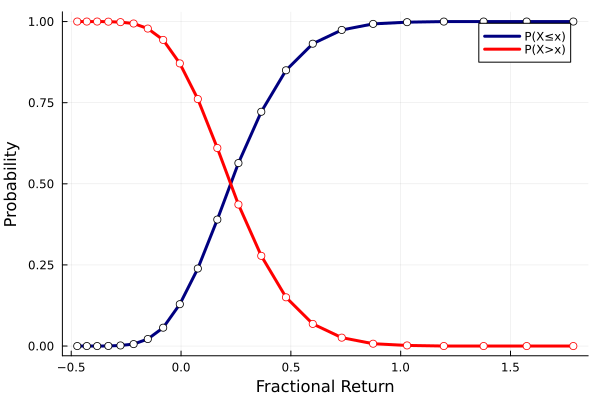

In [19]:
plot(reverse(cumulative_distribution_array[:,1]), reverse(cumulative_distribution_array[:,2]), 
    lw=3, c=:navyblue, label="P(X≤x)", xlabel="Fractional Return", ylabel = "Probability")
plot!(reverse(cumulative_distribution_array[:,1]), 1 .- reverse(cumulative_distribution_array[:,2]), 
    lw=3, c=:red, label="P(X>x)", xlabel="Fractional Return", ylabel = "Probability")
scatter!(reverse(cumulative_distribution_array[:,1]), reverse(cumulative_distribution_array[:,2]),
    lw=3, c=:white, mscc=:navyblue, label="")
scatter!(reverse(cumulative_distribution_array[:,1]), 1 .- reverse(cumulative_distribution_array[:,2]),
    lw=3, c=:white, msc=:red, label="")

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.